In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#from torch.optim import Adam
#import torch.nn.functional as F
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tslearn.metrics import SoftDTWLossPyTorch

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
import seaborn as sns
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import silhouette_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.cluster

import os
import scipy

from sklearn.metrics import adjusted_rand_score
import random

In [15]:
class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_length, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerTimeSeriesModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_length = seq_length
 
        # Input Encoder (maps input to d_model size)
        self.encoder = nn.Linear(input_dim, d_model)  # (Batch, 3) -> (Batch, d_model)
        
        # Project input to match the sequence length
        self.expand_input = nn.Linear(d_model, seq_length * d_model)  # (Batch, d_model) -> (Batch, seq_length * d_model)
        
        # Target embedding for decoder input
        self.target_embedding = nn.Linear(1, d_model)  # New embedding layer for target sequence
  
        # Positional Encoding for Time Steps
        self.pos_encoder = PositionalEncoding(d_model, seq_length)
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Final Output Layer
        self.output_layer = nn.Linear(d_model, output_dim)  # (Batch, 255, d_model) -> (Batch, 255, 1)

    def forward(self, x, target_seq):
        # x: Input features [Batch, 3]
        # target_seq: Target sequence for teacher forcing [Batch, 255, 1]
        
        # Encode input features
        encoded_input = self.encoder(x)  # [Batch, d_model]
        
        # Expand input to match sequence length
        expanded_input = self.expand_input(encoded_input)  # [Batch, seq_length * d_model]
        expanded_input = expanded_input.view(-1, self.seq_length, self.d_model)  # Reshape to [Batch, 255, d_model]
        
        # Add Positional Encoding
        expanded_input = self.pos_encoder(expanded_input)
        
        # Process the target sequence through the same encoding pipeline
  #      target_embeddings = self.encoder(target_seq)
  #      target_embeddings = nn.Linear(1, d_model)(target_seq)  # [Batch, 255, d_model]
        target_embeddings = self.target_embedding(target_seq)  # [Batch, 255, d_model]
        target_embeddings = self.pos_encoder(target_embeddings)
        
        # Decode sequence
        output = self.transformer_decoder(
            tgt=target_embeddings, memory=expanded_input
        )  # Output shape: [Batch, 255, d_model]
        
        # Map to output dimensions
        predictions = self.output_layer(output)  # [Batch, 255, 1]
        return predictions

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)

In [17]:
def ts_cluster_visualization(y_pred, df, n_clusters, plot_title):
    ts_size = df.shape[1]
    ts_max = df.max()
    plt.figure()
    for cluster in range(n_clusters):
        plt.subplot(4, math.ceil(n_clusters/4), cluster+1)
        for ts in df[y_pred == cluster]:
            plt.plot(ts.ravel(), "k-", alpha=.2)
        plt.plot(np.mean(df[y_pred == cluster], axis=0), "r-")
        plt.xlim(0, ts_size)
        plt.ylim(0, ts_max)
        plt.text(0.55, 0.35,'Cluster %d' % (cluster),
                 transform=plt.gca().transAxes)
        if cluster == 1:
            plt.title(plot_title)      
    plt.tight_layout()
    plt.show()

# N=1000

## Import Model

In [18]:
input_dim = 3      # Number of input features
output_dim = 1     # Predicting one value per time step
seq_length = 252   # Number of time steps in output
d_model = 128      # Embedding dimension for Transformer
nhead = 4          # Number of attention heads
num_layers = 2     # Number of Transformer layers
dim_feedforward = 512  # Feedforward network size

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeriesModel(
    input_dim, output_dim, seq_length, d_model, nhead, num_layers, dim_feedforward
).to(device)

checkpoint = torch.load('C:/Users/met48/Desktop/ABM-Surrogate/transformer_adamW_lr0001_epstein_no_pmax.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Evaluate model with validation inputs

In [32]:
data_val = pd.read_csv("C:/Users/met48/Desktop/ABM-Surrogate/validation_set_epstein_n1000.csv")
data_val = data_val.iloc[:, :3]  

In [33]:
model.eval()
with open('epsteinCV_gen_n1000.csv', 'w', newline='') as epsteinCV_inputs:
    for index, row in data_val.iterrows():
        cit_dens = row[0]
        cop_dens = row[1]
        leg = row[2]
        input_data = [[cit_dens, cop_dens, leg]]  
        target_data = [[0.5]] * seq_length  
        input_data = [input_data] 
        #target_data = [target_data]  
    
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        #target_tensor = torch.tensor(target_data, dtype=torch.float32)
    
        output = evaluate(model, input_tensor, 252)
        flattened_tensor = output.view(-1)
        
        numpy_array = flattened_tensor.detach().numpy()
        df = pd.DataFrame(numpy_array)
        print(*df[0].to_list(), file=epsteinCV_inputs, sep=",")
epsteinCV_inputs.close()

C:\Users\met48\AppData\Local\Temp\ipykernel_7176\2711730126.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cit_dens = row[0]
C:\Users\met48\AppData\Local\Temp\ipykernel_7176\2711730126.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cop_dens = row[1]
C:\Users\met48\AppData\Local\Temp\ipykernel_7176\2711730126.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  leg = row[2]


RuntimeError: shape '[1, 4, 32]' is invalid for input of size 32256

In [30]:
def evaluate(model, input_seq, target_length=255):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during inference
        batch_size = input_seq.size(0)  # Get the batch size
        predictions = []  # Store predictions

        # Initialize the target sequence (can be the last value or a dummy value)
        target_seq = torch.zeros(batch_size, 1, 1).to(input_seq.device)  # [Batch, 1, 1] (start token)

        # Make predictions sequentially (autoregressive)
        for step in range(target_length):
            # Forward pass
            output = model(input_seq, target_seq)  # Get the prediction for the next time step
            
            # Take the last predicted value (next time step)
            next_step = output[:, -1, :].unsqueeze(1)  # [Batch, 1, 1] (only the last time step)

            # Append the prediction to the sequence
            predictions.append(next_step)

            # Update target_seq by concatenating the last predicted value (autogressive)
            target_seq = torch.cat([target_seq, next_step], dim=1)  # [Batch, step+1, 1]

        # Concatenate all the predictions
        predictions = torch.cat(predictions, dim=1)  # [Batch, target_length, 1]
        return predictions

## Visualize generated data

C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


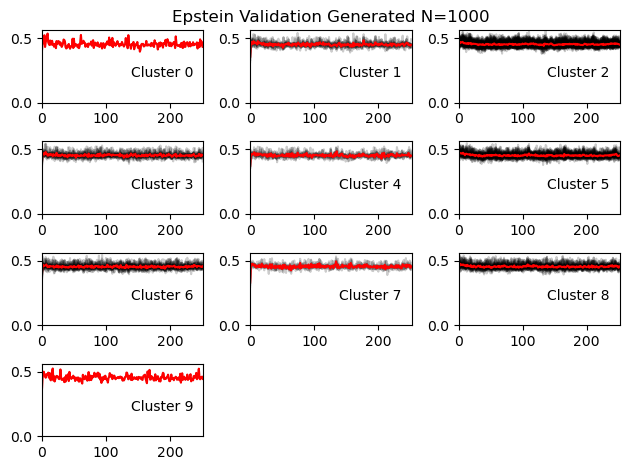

In [25]:
gen_data = pd.read_csv('epsteinCV_gen_n1000.csv', header=None)
data_val_ts = to_time_series_dataset(gen_data)
kmeans = TimeSeriesKMeans(n_clusters=10)
pred = kmeans.fit(data_val_ts)
ts_cluster_visualization(pred.labels_, data_val_ts, 10, "Epstein Validation Generated N=1000")

## Visualize validation data

In [26]:
data_val = pd.read_csv("C:/Users/met48/Desktop/ABM-Surrogate/validation_set_epstein_n1000.csv")
data_val = data_val.iloc[:, 3:]  

C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


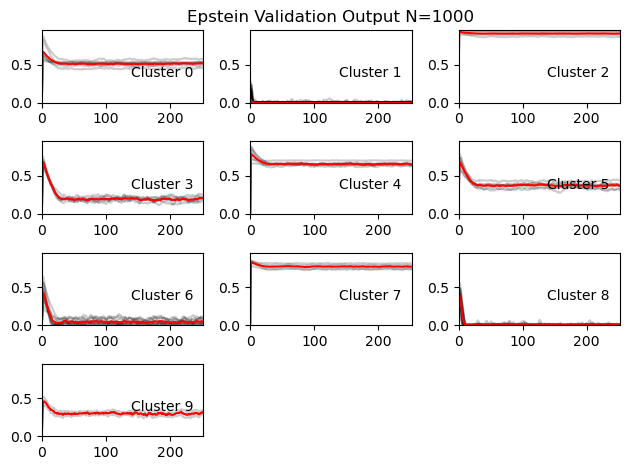

In [27]:
data_val_ts = to_time_series_dataset(data_val)
kmeans = TimeSeriesKMeans(n_clusters=10)
pred = kmeans.fit(data_val_ts)
ts_cluster_visualization(pred.labels_, data_val_ts, 10, "Epstein Validation Output N=1000")

# N = 5000